# 12_firm_growth_US_v18

In [1]:
import numpy as np
import pandas as pd

import fs_qe as fq

In this notebook, we 
1. focus on US firm data with a firm-size cut off of $\exp(8)$,
2. use Maximum Likelihood method to estimate 4 parameters and their standard errors with the US dataset from point $1.$ above,
   - also estimate the tail index for the firm size distribution from this dataset,
3. do scatter plots of $\log (S_{t+1}/S_t)$ against $\log S_t$ 
   - for the US dataset from point $1.$ above and 
   - for simulated data with the estimated parameters from point $2.$ above.


# 1 log-likelihood function and tail index: specification and implementation

## 1.1 log-likelihood specification

First we state the specification of the log-likelihood function we use here.

Assume that the law of motion for the firm size is

$$
\ln \frac{S_{t+1}}{S_{t}} = a + b \frac{1}{\ln S_t} \tag{1}
$$
where
- $S_t$ is the firm size at time $t$
- $a \sim_{iid} N(\mu_{a}, \sigma^2_{a})$
- $b \sim_{iid} N(\mu_{b}, \sigma^2_{b})$

Let $X_t := \frac{1}{\ln S_t}$ and $Y_t:=\ln \frac{S_{t+1}}{S_{t}}$.
The above law of motion can be rewritten as
$$
Y_t = a + b X_t \tag{2}
$$
while other intepretations are the same.



For the sum of independent random variables (you can find the wikipedia [here](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables)), we have the following conclusion that 

if
$$
X_i \sim_{iid} N(\mu_i, \sigma^2_i), i=1, \cdots, n
$$
then
$$
\sum^n_{i=1} a_i X_i \sim N( \sum^n_{i=1} a_i \mu_i, \sum^n_{i=1} (a_i \sigma_i)^2 )
$$

The above normal regression model can be regarded, equivalently, as a statement about the density of $Y$ given $X$.

The conditional density is
$$
f_{Y|X} (y |x, \mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp (- \frac{1}{2 \sigma^2} (y - \mu_{a} - \mu_{b} x )^2 ) \tag{3}
$$
where
- $\sigma^2 = \sigma^2_{a} + \sigma^2_{b} (x)^2$

The likelihood function is
$$
\mathscr L (\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b} | x, y) = \prod^n_{i=1} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp (- \frac{1}{2 \sigma^2} (y - \mu_{a} - \mu_{b} x )^2 )  \tag{4}
$$

Taking log of $(4)$, we have the log-likelihood function
$$
L (\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b} | x, y) = \sum^n_{i=1}\ln \frac{1}{\sqrt{2 \pi \sigma^2}} \exp (- \frac{1}{2 \sigma^2} (y - \mu_{a} - \mu_{b} x )^2 )  \tag{5}
$$

## 1.2 tail index specification

Recall equation [(1)](#), let $S_t \to \infty$, we have

$$
\ln \frac{S_{t+1}}{S_{t}} = a \tag{6}
$$

Taking logarithm of both yields

$$
\frac{S_{t+1}}{S_{t}} = \exp (a) \tag{7}
$$

By [Kesten-Goldien Theorem](https://python.quantecon.org/kesten_processes.html#The-Kesten%E2%80%93Goldie-Theorem), we have a positive constant $\alpha$, which is the tail index of the Pareto distribution followed by the stationary firm size distribution, such that

$$
\mathbb E (\exp (a)^{\alpha} ) = 1 \tag{8}
$$

By the property of exponential functions, $a \sim N(\mu_a, \sigma^2_a)$ and lognormal distribution, let $\epsilon \sim N(0, 1)$ equation [(8)](#) can be rewritten as

$$
\mathbb E (\exp (a)^{\alpha} ) =  \mathbb E (\exp (\mu_a + \sigma_a \epsilon)^{\alpha} )\\
= \mathbb E (\exp (\mu_a \alpha + \sigma_a \epsilon \alpha) ) \\
= \exp (  \alpha \mu_a + \frac{\sigma^2_a \alpha^2}{2} ) =1 \tag{9}
$$
or equivalently
$$
\exp (  \alpha \mu_a + \frac{\sigma^2_a \alpha^2}{2} ) =1 \tag{10}
$$

Taking logarithm of both sides of [(10)](#) yields

$$
\alpha \mu_a + \frac{\sigma^2_a \alpha^2}{2} =0 \tag{11}
$$

Rearrange [(11)](#), we get

$$
\alpha = - \frac{2 \mu_a}{\sigma^2_a} \tag{12}
$$

For the following parts, we estimate the tail index $\alpha$ of the stationary distribution using equation [(12)](#).

## 1.3 implementation

Then we implement the log-likelihood function and the tail index measure, $\alpha$.

# 2 ML estimations for sample with cutoff of $\exp (8)$ and initial set of parameters $(0, 0, 10,10)$

Now we import the US firm database with firm-size cutoff of $\exp(8)$.

In [2]:
%%time
df = pd.read_csv('data/usa_chop_log8.csv')
df

CPU times: user 264 ms, sys: 57.8 ms, total: 322 ms
Wall time: 338 ms


,year,id,tasset,logtasset,fgrow_log,logtasset_inv
0,2010,1,180782000.0,19.012802,-6.749972,0.052596
1,2011,1,193406000.0,19.080302,-4.893148,0.052410
2,2012,1,203105000.0,19.129234,-0.807152,0.052276
3,2013,1,204751000.0,19.137305,0.617774,0.052254
4,2014,1,203490000.0,19.131127,1.939669,0.052271
...,...,...,...,...,...,...
197111,2018,39566,971579.0,13.786678,87.515404,0.072534
197112,2018,39582,96026.0,11.472374,0.000000,0.087166
197113,2017,39592,99948.0,11.512405,0.000000,0.086863
197114,2018,39592,99948.0,11.512405,0.000000,0.086863


In [3]:
df['const'] = 1
df['tasset_inv'] = 1 / df['tasset']
df['tasset_inv_onehalf'] = (df['tasset_inv']) ** (1/2)
df['tasset_inv_onefour'] = (df['tasset_inv']) ** (1/4)
df['tasset_logmax'] = 20 - df['logtasset']
df.loc[df['tasset_logmax'] < 0.0, 'tasset_logmax'] = 0.0
# df['fgrow_log'] = df['fgrow_log'] / 100
df

,year,id,tasset,logtasset,fgrow_log,logtasset_inv,const,tasset_inv,tasset_inv_onehalf,tasset_inv_onefour,tasset_logmax
0,2010,1,180782000.0,19.012802,-6.749972,0.052596,1,5.531524e-09,0.000074,0.008624,0.987198
1,2011,1,193406000.0,19.080302,-4.893148,0.052410,1,5.170470e-09,0.000072,0.008480,0.919698
2,2012,1,203105000.0,19.129234,-0.807152,0.052276,1,4.923562e-09,0.000070,0.008377,0.870766
3,2013,1,204751000.0,19.137305,0.617774,0.052254,1,4.883981e-09,0.000070,0.008360,0.862695
4,2014,1,203490000.0,19.131127,1.939669,0.052271,1,4.914246e-09,0.000070,0.008373,0.868873
...,...,...,...,...,...,...,...,...,...,...,...
197111,2018,39566,971579.0,13.786678,87.515404,0.072534,1,1.029252e-06,0.001015,0.031852,6.213322
197112,2018,39582,96026.0,11.472374,0.000000,0.087166,1,1.041385e-05,0.003227,0.056807,8.527626
197113,2017,39592,99948.0,11.512405,0.000000,0.086863,1,1.000520e-05,0.003163,0.056241,8.487595
197114,2018,39592,99948.0,11.512405,0.000000,0.086863,1,1.000520e-05,0.003163,0.056241,8.487595


For equation [(2)](), we consider three cases of $X$:
- $X= 1/ S^{1/4}_t$
- $X = 1/ \ln (S_t)$
- $X = max \{ u - \ln S_t,  0 \}$, where $u =20$


## 2.1 when $\mu_b$ free

### 2.1.1 case i: when $X= S^{-1/4}_t$

In [4]:
opt_res1, μ_σ1, se1 = fq.mle_mean_var_se(df, x='tasset_inv_onefour', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [5]:
print(opt_res1)

      fun: 925207.417778822
 hess_inv: array([[ 0.00253906, -0.00200901,  0.0004416 , -0.00391475],
       [-0.00200901,  0.001594  , -0.00029121,  0.00292856],
       [ 0.0004416 , -0.00029121,  0.00085544, -0.00294073],
       [-0.00391475,  0.00292856, -0.00294073,  0.0125947 ]])
      jac: array([-18.5234375,   0.921875 ,  29.0390625,   0.421875 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1077
      nit: 25
     njev: 177
   status: 2
  success: False
        x: array([  -5.98004036,    5.38873027,   19.291511  , 1876.46951545])


In [6]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ1[0], μ_σ1[1], μ_σ1[2],  μ_σ1[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -5.9800403644432585 5.388730268790827 19.291510998337984 1876.4695154544597


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [7]:
print(se1)

[0.05038905 0.03992488 0.02924798 0.11222611]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [8]:
α = fq.alpha(μ_σ1[0], μ_σ1[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is 2.2194617530133365


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2.1.2 case ii: when $X = 1/ \ln (S_t)$

#### estimation

In [9]:
opt_res2, μ_σ2, se2 = fq.mle_mean_var_se(df, x='logtasset_inv', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [10]:
print(opt_res2)

      fun: 926329.6828881726
 hess_inv: array([[ 0.00178051, -0.00535074,  0.00018954, -0.00587788],
       [-0.00535074,  0.0651952 , -0.00394426,  0.05789564],
       [ 0.00018954, -0.00394426,  0.00122719, -0.00289736],
       [-0.00587788,  0.05789564, -0.00289736,  0.07986976]])
      jac: array([ 0.8203125,  0.2578125, -0.90625  , -0.3046875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 642
      nit: 39
     njev: 105
   status: 2
  success: False
        x: array([  -5.3861355 ,   -2.99627238,    9.84261865, 2225.667973  ])


In [11]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ2[0], μ_σ2[1], μ_σ2[2],  μ_σ2[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -5.386135496963321 -2.996272382154653 9.842618653237777 2225.667973001784


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [12]:
print(se2)

[0.04219614 0.25533351 0.03503124 0.28261238]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [13]:
α = fq.alpha(μ_σ2[0], μ_σ2[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is -3.595224205277419


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2.1.3 case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

In [14]:
opt_res3, μ_σ3, se3 = fq.mle_mean_var_se(df, x='tasset_logmax', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [15]:
print(opt_res3)

      fun: 1446935.6855437276
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([   22.46875,    46.8125 ,   382.15625, 19105.375  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 120
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([ 0.,  0., 10., 10.])


In [16]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ3[0], μ_σ3[1], μ_σ3[2],  μ_σ3[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are 0.0 0.0 10.0 10.0


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [17]:
print(se3)

[1. 1. 1. 1.]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [18]:
α = fq.alpha(μ_σ3[0], μ_σ3[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is nan


/Users/shuhu/Desktop/1_papers_w:john/04_firm_size/github/firm_size_empirics/orbis/firm_growth_asset/fs_qe.py:244: RuntimeWarning: invalid value encountered in double_scalars
  return - 2 * μ / σ2


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

## 2.2 when $\mu_b =0$

### 2.2.1 case i: when $X= S^{-1/4}_t$

In [19]:
opt_res4, μ_σ4, se4 = fq.mle_mean_var_se(df, x='tasset_inv_onefour', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [20]:
print(opt_res4)

      fun: 925207.417778822
 hess_inv: array([[ 0.00253906, -0.00200901,  0.0004416 , -0.00391475],
       [-0.00200901,  0.001594  , -0.00029121,  0.00292856],
       [ 0.0004416 , -0.00029121,  0.00085544, -0.00294073],
       [-0.00391475,  0.00292856, -0.00294073,  0.0125947 ]])
      jac: array([-18.5234375,   0.921875 ,  29.0390625,   0.421875 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1077
      nit: 25
     njev: 177
   status: 2
  success: False
        x: array([  -5.98004036,    5.38873027,   19.291511  , 1876.46951545])


In [21]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ4[0], μ_σ4[1], μ_σ4[2],  μ_σ4[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -5.9800403644432585 5.388730268790827 19.291510998337984 1876.4695154544597


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [22]:
print(se4)

[0.05038905 0.03992488 0.02924798 0.11222611]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [23]:
α = fq.alpha(μ_σ4[0], μ_σ4[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is 2.2194617530133365


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2.2.2 case ii: when $X = 1/ \ln (S_t)$


In [24]:
opt_res5, μ_σ5, se5 = fq.mle_mean_var_se(df, x='logtasset_inv', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [25]:
print(opt_res5)

      fun: 926329.6828881726
 hess_inv: array([[ 0.00178051, -0.00535074,  0.00018954, -0.00587788],
       [-0.00535074,  0.0651952 , -0.00394426,  0.05789564],
       [ 0.00018954, -0.00394426,  0.00122719, -0.00289736],
       [-0.00587788,  0.05789564, -0.00289736,  0.07986976]])
      jac: array([ 0.8203125,  0.2578125, -0.90625  , -0.3046875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 642
      nit: 39
     njev: 105
   status: 2
  success: False
        x: array([  -5.3861355 ,   -2.99627238,    9.84261865, 2225.667973  ])


In [26]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ5[0], μ_σ5[1], μ_σ5[2],  μ_σ5[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -5.386135496963321 -2.996272382154653 9.842618653237777 2225.667973001784


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [27]:
print(se5)

[0.04219614 0.25533351 0.03503124 0.28261238]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [28]:
α = fq.alpha(μ_σ5[0], μ_σ5[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is -3.595224205277419


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2.2.3 case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

In [29]:
opt_res6, μ_σ6, se6 = fq.mle_mean_var_se(df, x='tasset_logmax', y='fgrow_log')

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [30]:
print(opt_res6)

      fun: 1446935.6855437276
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([   22.46875,    46.8125 ,   382.15625, 19105.375  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 120
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([ 0.,  0., 10., 10.])


In [31]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ6[0], μ_σ6[1], μ_σ6[2],  μ_σ6[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are 0.0 0.0 10.0 10.0


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [32]:
print(se6)

[1. 1. 1. 1.]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [33]:
α = fq.alpha(μ_σ6[0], μ_σ6[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is nan


/Users/shuhu/Desktop/1_papers_w:john/04_firm_size/github/firm_size_empirics/orbis/firm_growth_asset/fs_qe.py:244: RuntimeWarning: invalid value encountered in double_scalars
  return - 2 * μ / σ2


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

# 2*** initial set of parameters $(1, 1, 10,10)$

## 2***.1 when $\mu_b$ free

### 2***.1.1 case i: when $X= S^{-1/4}_t$

In [34]:
opt_res1, μ_σ1, se1 = fq.mle_mean_var_se(df, x='tasset_inv_onefour', y='fgrow_log', x_zero=[1, 1, 10, 10])

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [35]:
print(opt_res1)

      fun: 925223.6551428307
 hess_inv: array([[ 2.02125892e-03, -3.74071987e-03, -1.57157899e-04,
         3.09773658e-03],
       [-3.74071987e-03,  1.06993012e-01, -1.09910213e-03,
        -7.48782509e-02],
       [-1.57157899e-04, -1.09910213e-03,  6.43853575e-04,
        -2.74595447e-03],
       [ 3.09773658e-03, -7.48782509e-02, -2.74595447e-03,
         1.26380794e+00]])
      jac: array([ 1.734375 ,  0.6015625, -1.1171875,  0.078125 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 714
      nit: 33
     njev: 117
   status: 2
  success: False
        x: array([-5.66639932e+00,  2.71948238e-01,  1.97329634e+01,  1.70487307e+03])


In [36]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ1[0], μ_σ1[1], μ_σ1[2],  μ_σ1[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -5.66639931964878 0.2719482384111752 19.73296341932421 1704.873068670573


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [37]:
print(se1)

[0.04495841 0.32709786 0.02537427 1.12419213]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [38]:
α = fq.alpha(μ_σ1[0], μ_σ1[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is 41.67263117977181


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2***.1.2 case ii: when $X = 1/ \ln (S_t)$

#### estimation

In [39]:
opt_res2, μ_σ2, se2 = fq.mle_mean_var_se(df, x='logtasset_inv', y='fgrow_log', x_zero=[1, 1, 10, 10])

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [40]:
print(opt_res2)

      fun: 926330.0884759661
 hess_inv: array([[ 6.00584268e-03, -4.13035523e-02, -1.52754223e-03,
         2.81534063e-01],
       [-4.13035523e-02,  4.17585258e-01,  1.58223599e-02,
        -2.72727295e+00],
       [-1.52754223e-03,  1.58223599e-02,  3.21312887e-03,
        -2.71889388e-01],
       [ 2.81534063e-01, -2.72727295e+00, -2.71889388e-01,
         4.43075780e+01]])
      jac: array([ 4.5546875,  0.671875 , -3.3984375, -0.0234375])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 522
      nit: 23
     njev: 85
   status: 2
  success: False
        x: array([  -4.66085871,  -11.88285111,    9.86334953, 2221.57291172])


In [41]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ2[0], μ_σ2[1], μ_σ2[2],  μ_σ2[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are -4.660858714814596 -11.882851114811599 9.86334952938808 2221.572911722447


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [42]:
print(se2)

[0.07749737 0.64620837 0.05668447 6.65639377]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [43]:
α = fq.alpha(μ_σ2[0], μ_σ2[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is -0.7844680825807845


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

### 2***.1.3 case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

In [44]:
opt_res3, μ_σ3, se3 = fq.mle_mean_var_se(df, x='tasset_logmax', y='fgrow_log', x_zero=[1, 1, 10, 10])

The following shows a summary of the maximum likelihood estimators for $(\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b})$, respectively:

In [45]:
print(opt_res3)

      fun: 1447038.3130164568
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([   40.734375,    97.078125,   373.796875, 19081.671875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 120
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([ 1.,  1., 10., 10.])


In [46]:
print('estimated μ_a, μ_b, σ^2_a,  σ^2_b are', μ_σ3[0], μ_σ3[1], μ_σ3[2],  μ_σ3[3])

estimated μ_a, μ_b, σ^2_a,  σ^2_b are 1.0 1.0 10.0 10.0


The following shows the standard errors for the estimators of $(\mu_{\alpha}, \mu_{\beta}, \sigma^2_{\alpha}, \sigma^2_{\beta})$, respectively:

In [47]:
print(se3)

[1. 1. 1. 1.]


The following shows the estimated tail index $\alpha$ using the estimators $(\mu_a, \sigma^2_a)$ and equation [(12)]() above.

In [48]:
α = fq.alpha(μ_σ3[0], μ_σ3[1])
print('The tail index α of the stationary firm size distribution is', α)

The tail index α of the stationary firm size distribution is -2.0


We can compare our this with the tail index $\alpha$ of the stationary firm size distribution, measured by [Axtell (2001)](https://science.sciencemag.org/content/293/5536/1818) using OLS, which is $1.059$.

# 3 scatter plots of $\log (S_{t+1}/S_t) * 100$ against $\log S_t$

Next we simulate firm-size and firm-growth data with those estimated parameters from ``2.``.

## 3.1 functions for simulations

Here are two functions for simulations.

## 3.2 scatter plots for real-world data

Let's plot the scatter points for the US firm-size data.

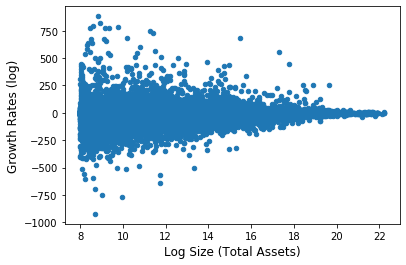

In [49]:
fq.scatterplot(df, x='logtasset', xlabel='Log Size (Total Assets)')

## 3.3 scatter plots for simulated data when $\mu_b$ is free

### 3.3.1 simulating data and plots with the estimated parameters from ``2.1.1``: when $X= S^{-1/4}_t$

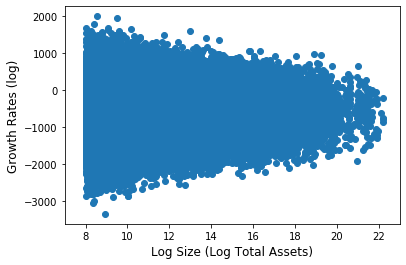

In [50]:
fq.simplot(opt_res1, df)

### 3.3.2 simulating data and plots with the estimated parameters from ``2.1.2``: when $X= 1/ \ln S_t$

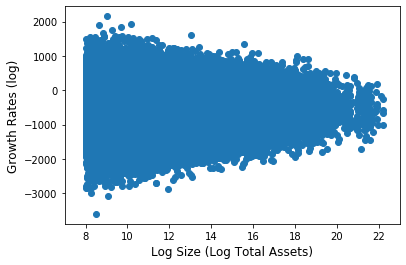

In [51]:
fq.simplot(opt_res2, df, m='2')

### 3.3.3 simulating data and plots with the estimated parameters from ``2.1.3``: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

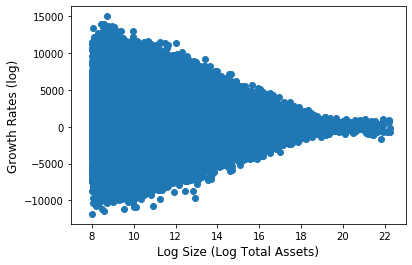

In [52]:
fq.simplot(opt_res3, df, m='3')

## 3.4 scatter plots for simulated data when $\mu_b=0$

### 3.4.1 simulating data and plots with the estimated parameters from ``2.2.1``: when $X= S^{-1/4}_t$

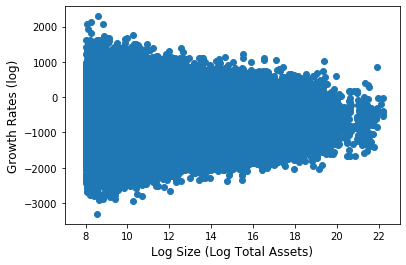

In [53]:
fq.simplot(opt_res4, df, m='1')

### 3.4.2 simulating data and plots with the estimated parameters from ``2.2.2``: when $X = 1/ \ln (S_t)$

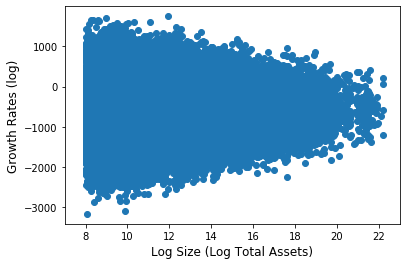

In [54]:
fq.simplot(opt_res5, df, m='2')

### 3.4.3 simulating data and plots with the estimated parameters from ``2.2.3``: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

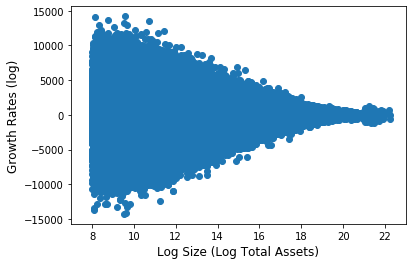

In [55]:
fq.simplot(opt_res6, df, m='3')

# 4 histograms for mean and standard deviation of firm growth against $\ln S$

## 4.1 process real-world data

In [56]:
df1 = df[['id', 'year', 'tasset', 'logtasset', 'fgrow_log']]
df2 = df1[df1['fgrow_log'] != 0.0]
df3 = df2.sort_values('logtasset').reset_index(drop=True)
df3.index += 1
df3.index.name = 'count'
df4 = df3.reset_index()
df4['quantile_ex_1'] = pd.qcut(df4['logtasset'], q=12)
df5 = df4.groupby('quantile_ex_1').mean().reset_index()
df6 = df4.groupby('quantile_ex_1').std().reset_index()
df6['tasset_mean'] = df5['tasset']

df1

,id,year,tasset,logtasset,fgrow_log
0,1,2010,180782000.0,19.012802,-6.749972
1,1,2011,193406000.0,19.080302,-4.893148
2,1,2012,203105000.0,19.129234,-0.807152
3,1,2013,204751000.0,19.137305,0.617774
4,1,2014,203490000.0,19.131127,1.939669
...,...,...,...,...,...
197111,39566,2018,971579.0,13.786678,87.515404
197112,39582,2018,96026.0,11.472374,0.000000
197113,39592,2017,99948.0,11.512405,0.000000
197114,39592,2018,99948.0,11.512405,0.000000


## 4.2 histogram for mean and standard deviation growth against $\ln S$- from real-world data

In [57]:
def barplots2(df):
    ax = df.plot.bar('quantile_ex_1', 'fgrow_log')
    ax.set_xlabel('log firm size bins',fontsize=14)
    ax.set_ylabel('growth mean $\%$',fontsize=14)

### 4.2.1 histogram and simulated lines for mean growth against $\ln S$

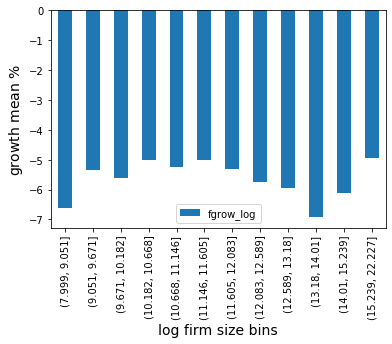

In [58]:
fq.barplots2(df5)

### 4.2.2 histogram for standard deviation of growth against $\ln S$

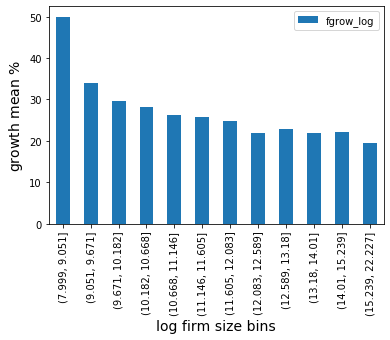

In [59]:
fq.barplots2(df6)

# 5 analytical solutions and their plots for mean and standard deviation of growth from the model

## 5.1 analytical solution for mean and sd of growth from the model

Recall equation [(1)](), taking the expected value of its both sides yields

$$
\mathbb E (\ln \frac{S_{t+1}}{S_{t}}) = \mathbb E (a + b / \ln (S_t))  \\
= E(a) + E(b) / \ln (S_t) \\
= \mu_a + \mu_b / \ln (S_t) \tag{13}
$$

Taking the variance of the both sides of [(1)](), we have

$$
Var (\ln \frac{S_{t+1}}{S_{t}}) = Var ( a+ b / \ln (S_t)) \\
= \sigma^2_a + \sigma^2_b / (\ln S_t)^2 \tag{14}
$$

And taking square root of [(14)](), we get

$$
SD(\ln \frac{S_{t+1}}{S_{t}}) = \sqrt{ \sigma^2_a + \sigma^2_b / (\ln S_t)^2  } \tag{15}
$$

We can implement these two analytical solutions with estimations from ``2.1.1`` as default parameters.

### process the data

In [71]:
df5['fgrow_mean_sim1'] = mean_growth1(df5['tasset'])
df5['fgrow_mean_sim2'] = mean_growth2(df5['tasset'])
df5['fgrow_mean_sim3'] = mean_growth3(df5['tasset'])
df5['fgrow_mean_sim4'] = mean_growth1(df5['tasset'], paras=opt_res4.x)
df5['fgrow_mean_sim5'] = mean_growth2(df5['tasset'], paras=opt_res5.x)
df5['fgrow_mean_sim6'] = mean_growth3(df5['tasset'], paras=opt_res6.x)
df5

,quantile_ex_1,count,id,year,tasset,logtasset,fgrow_log,fgrow_mean_sim1,fgrow_mean_sim2,fgrow_mean_sim3,fgrow_mean_sim4,fgrow_mean_sim5,fgrow_mean_sim6
0,"(7.999, 9.051]",8211.5,23697.767020,2014.032517,5.673371e+03,8.602317,-6.623679,-5.635065,-5.634937,12.356461,-5.359134,-5.732784,0.0
1,"(9.051, 9.671]",24633.5,20830.174522,2014.099014,1.200433e+04,9.377457,-5.357622,-5.640419,-5.637447,11.606978,-5.465224,-5.705125,0.0
2,"(9.671, 10.182]",41056.5,18819.908061,2014.171639,2.079348e+04,9.931652,-5.614329,-5.643753,-5.639047,11.057605,-5.531290,-5.687499,0.0
3,"(10.182, 10.668]",57478.5,17476.217783,2014.198660,3.401399e+04,10.424658,-5.023661,-5.646374,-5.640337,10.565473,-5.583240,-5.673285,0.0
4,"(10.668, 11.146]",73898.5,16082.868088,2014.287881,5.516903e+04,10.908609,-5.257733,-5.648655,-5.641491,10.081843,-5.628429,-5.660566,0.0
5,"(11.146, 11.605]",90319.5,14721.195896,2014.285532,8.824301e+04,11.379081,-5.008835,-5.650621,-5.642519,9.612150,-5.667385,-5.649247,0.0
6,"(11.605, 12.083]",106741.5,13122.123249,2014.229996,1.397616e+05,11.838114,-5.299331,-5.652334,-5.643446,9.152306,-5.701339,-5.639035,0.0
7,"(12.083, 12.589]",123163.0,11473.795749,2014.191584,2.295087e+05,12.333205,-5.734996,-5.653975,-5.644368,8.656304,-5.733841,-5.628873,0.0
8,"(12.589, 13.18]",139584.5,9676.860614,2014.288576,3.945910e+05,12.871177,-5.944172,-5.655549,-5.645295,8.114395,-5.765035,-5.618664,0.0
9,"(13.18, 14.01]",156006.0,7758.848060,2014.337799,8.089018e+05,13.574690,-6.930366,-5.657331,-5.646408,7.396567,-5.800355,-5.606394,0.0


In [72]:
df6['fgrow_log_var_sim1'] = sd_growth1(df6['tasset_mean'])
df6['fgrow_log_var_sim2'] = sd_growth2(df6['tasset_mean'])
df6['fgrow_log_var_sim3'] = sd_growth3(df6['tasset_mean'])
df6['fgrow_log_var_sim4'] = sd_growth1(df6['tasset_mean'], paras=opt_res4.x)
df6['fgrow_log_var_sim5'] = sd_growth2(df6['tasset_mean'], paras=opt_res5.x)
df6['fgrow_log_var_sim6'] = sd_growth3(df6['tasset_mean'], paras=opt_res6.x)
df6

,quantile_ex_1,count,id,year,tasset,logtasset,fgrow_log,tasset_mean,fgrow_log_var_sim1,fgrow_log_var_sim2,fgrow_log_var_sim3,fgrow_log_var_sim4,fgrow_log_var_sim5,fgrow_log_var_sim6
0,"(7.999, 9.051]",4740.767396,6920.606246,2.444321,1.580606e+03,0.292324,50.022291,5.673371e+03,6.509032,6.292773,36.051243,6.648625,6.295481,36.051243
1,"(9.051, 9.671]",4740.767396,6412.874698,2.464621,2.100206e+03,0.177344,34.033297,1.200433e+04,5.940829,5.919714,33.690945,6.034747,5.921883,33.690945
2,"(9.671, 10.182]",4741.344746,6373.638383,2.471184,3.038231e+03,0.146893,29.514057,2.079348e+04,5.617471,5.686586,31.961762,5.683707,5.688405,31.961762
3,"(10.182, 10.668]",4740.190045,6674.619273,2.470830,4.775962e+03,0.140610,28.217548,3.401399e+04,5.383032,5.501576,30.413528,5.428260,5.503110,30.413528
4,"(10.668, 11.146]",4740.190045,6827.434747,2.481875,7.614675e+03,0.138338,26.277170,5.516903e+04,5.195327,5.338515,28.892884,5.223077,5.339791,28.892884
5,"(11.146, 11.605]",4740.767396,6897.814451,2.490688,1.165996e+04,0.132642,25.825230,8.824301e+04,5.046996,5.195587,27.416989,5.060472,5.196631,27.416989
6,"(11.605, 12.083]",4740.767396,6639.245390,2.516208,1.937660e+04,0.138377,24.732990,1.397616e+05,4.928825,5.068545,25.973082,4.930605,5.069377,25.973082
7,"(12.083, 12.589]",4740.478721,7078.691534,2.508564,3.324442e+04,0.144938,22.014511,2.295087e+05,4.826145,4.944064,24.417000,4.817510,4.944686,24.417000
8,"(12.589, 13.18]",4740.767396,7071.281163,2.487377,6.731080e+04,0.169645,22.946830,3.945910e+05,4.737828,4.821119,22.718850,4.720036,4.821527,22.718850
9,"(13.18, 14.01]",4740.478721,7092.393753,2.498346,1.949104e+05,0.239516,21.870344,8.089018e+05,4.650651,4.676365,20.473415,4.623623,4.676514,20.473415


## 5.2 plots

### 5.2.1 histogram and analytical solution line for mean growth against $\ln S$

#### 5.2.1.1 when $\mu_b$ free

##### case i: when $X= S^{-1/4}_t$

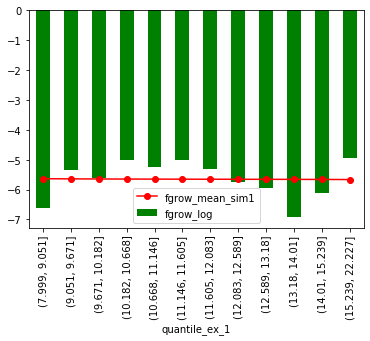

In [74]:
fq.bslplot(df5, y='fgrow_mean_sim1')

##### case ii: when $X = 1/ \ln (S_t)$

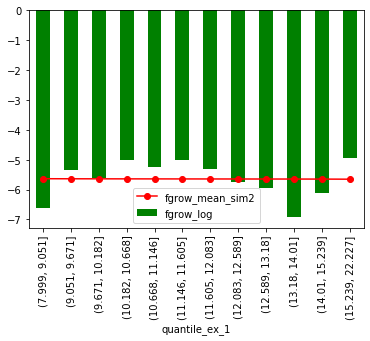

In [75]:
fq.bslplot(df5, y='fgrow_mean_sim2')

##### case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

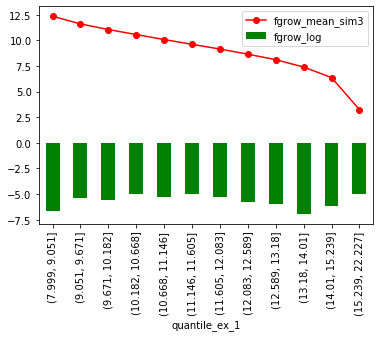

In [76]:
fq.bslplot(df5, y='fgrow_mean_sim3')

#### 5.2.1.2 when $\mu_b=0$

##### case i: when $X= S^{-1/4}_t$

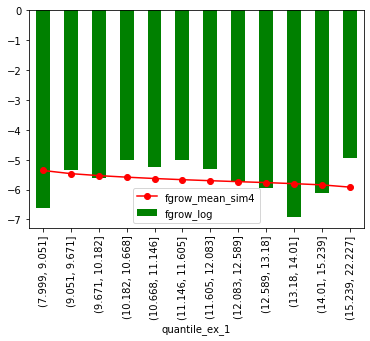

In [77]:
fq.bslplot(df5, y='fgrow_mean_sim4')

##### case ii: when $X = 1/ \ln (S_t)$

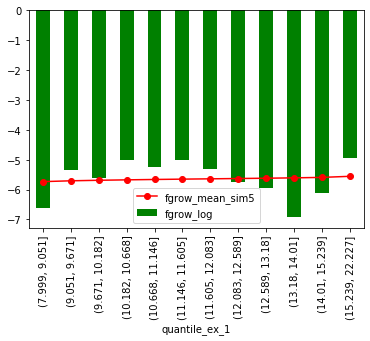

In [78]:
fq.bslplot(df5, y='fgrow_mean_sim5')

##### case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

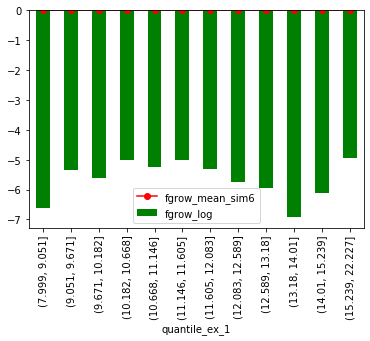

In [79]:
fq.bslplot(df5, y='fgrow_mean_sim6')

### 5.2.2 histogram and analytical solution line for standard deviation of growth against $\ln S$

#### 5.2.2.1 when $\mu_b$ free

##### case i: when $X= S^{-1/4}_t$

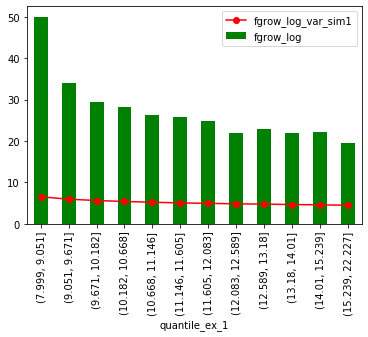

In [80]:
fq.bslplot(df6, y='fgrow_log_var_sim1')

##### case ii: when $X = 1/ \ln (S_t)$

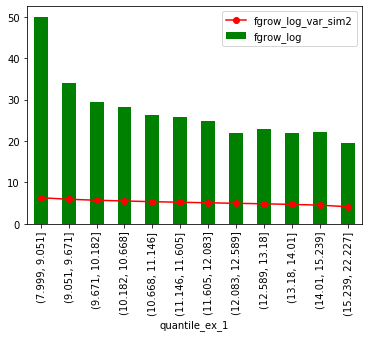

In [81]:
fq.bslplot(df6, y='fgrow_log_var_sim2')

##### case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

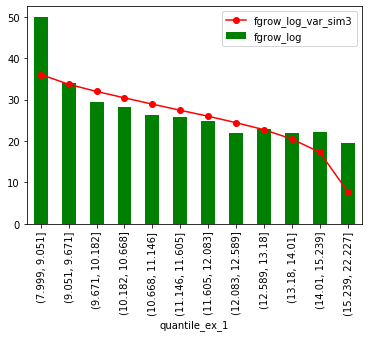

In [82]:
fq.bslplot(df6, y='fgrow_log_var_sim3')

#### 5.2.2.2 when $\mu_b=0$

##### case i: when $X= S^{-1/4}_t$

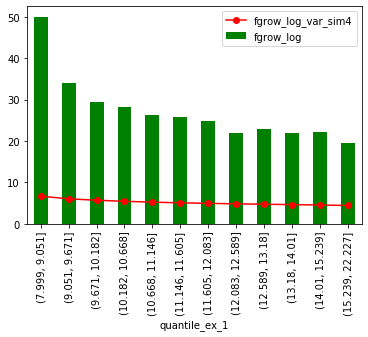

In [83]:
fq.bslplot(df6, y='fgrow_log_var_sim4')

##### case ii: when $X = 1/ \ln (S_t)$

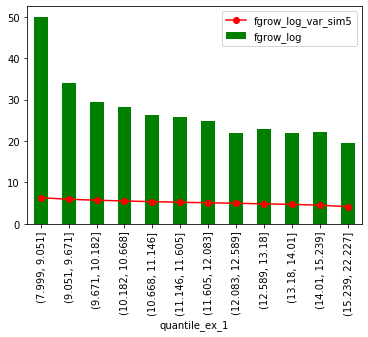

In [84]:
fq.bslplot(df6, y='fgrow_log_var_sim5')

##### case iii: when $X = max\{ u - \ln (S_t), 0\}$, where $u=20$

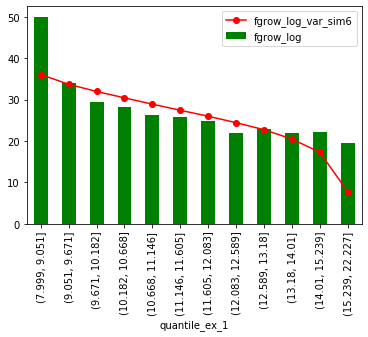

In [85]:
fq.bslplot(df6, y='fgrow_log_var_sim6')

# 6 closed-form solutions for MLE

Recall the log-likelihood function
$$
L (\mu_{a}, \mu_{b}, \sigma^2_{a}, \sigma^2_{b} | x, y) = \sum^n_{i=1}\ln \frac{1}{\sqrt{2 \pi \sigma^2}} \exp (- \frac{1}{2 \sigma^2} (y - \mu_{a} - \mu_{b} x )^2 )  \tag{5}
$$

Taking FOC with respect to $\mu_a, \mu_b, \sigma^2_a $ and $\sigma^2_b$ respectively, we have

$$
\sum^N_{i=1} \frac{y_i - \mu_i}{\sigma^2_i}=0 \tag{16}
$$

$$
\sum^N_{i=1} \frac{y_i - \mu_i}{\sigma^2_i} x_i=0 \tag{17}
$$


$$
\sum^N_{i=1} [-1/2 (\sigma^2_i)^{-1} + (y_i - \mu_i)^2 (\sigma^2_i)^{-2} ]=0 \tag{18}
$$

$$
\sum^N_{i=1} [-1/2 (\sigma^2_i)^{-1} + (y_i - \mu_i)^2 (\sigma^2_i)^{-2} ]x^2_i=0 \tag{19}
$$



where
- $\mu_i = \mu_a + \mu_b x_i$,
- $\sigma^2_i= \sigma^2_a + \sigma^2_b x^2_i$.

Solving equations [(16)](), [(17)](), [(18)](), and [(19)]() for $\mu_a, \mu_b, \sigma^2_a, \sigma^2_b$.